# HW3 - Scraping and Regression
In this assignment we'll analyze some data from the tech news site HackerNews (Links to an external site.). HN has a nice simple HTML table format which makes our scraping less painful than some other websites (cough github cough).

In [125]:
# Imports

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns


## Part 1 - Data Acquisition
Check out the robots.txt file for HN to make sure you're allowed to scrape it for stories.

Grab the first 5 pages of stories from hackernews. For each story, grab the following data:

* Rank (the number of the story on hacker news)
* Length of the title
* Age, in hours (note, some stories are days or minutes old. You should be able to handle this)
* Points (note, some stories don't have scores! Give them 0 points)
* Number of comments (again, some stories have no comments. Mark them 0)
* A lot of HTML on HN has handy class attributes to help make this task a bit easier. Once you have all your data, create a dataframe to store it, and save a CSV file so you don't have to hit the server repeatedly to reload the data.

Most of the table entries are nicely, uniformly formatted, but a few might be missing fields. I'd suggest testing with the common case and fixing edge cases as they come up.

### Scraping setup

In [126]:
# URL for scraping
URL = 'https://news.ycombinator.com/news?p='

# User Agent Setup
headers = {"User-agent" : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.5 Safari/605.1.15'}

ranks = []
title_lengths = []
ages_in_hours = []
points = []
comment_counts = []

def scrape(n):
    page = requests.get(f'{URL}{n}', headers=headers)
    soup = BeautifulSoup(page.content, 'html.parser')

    # Find ranks
    for rank in soup.find_all('span', class_='rank'):
        ranks.append(int(rank.get_text().strip().replace('.', '')))

    # Title length
    for title in soup.find_all('a', class_='titlelink'):
        title_lengths.append(len(title.text.strip()))


    # Number of comments
    for row in soup.find_all('td', class_='subtext'):
        # Age
        age = row.find("span", class_='age').find('a')
        if age is None:
            ages_in_hours.append(float(0))
        elif 'minute' in age.text:
            ages_in_hours.append(float(age.text.strip().replace(" minute ago", '').replace('minutes ago', ''))/60)
        elif 'day' in age.text:
            ages_in_hours.append(float(age.text.strip().replace(" day ago", '').replace('days ago', ''))*24)
        else:
            ages_in_hours.append(float(age.text.strip().replace(" hour ago", '').replace('hours ago', '')))

        # Points
        score = row.find("span", class_='score')
        if score is None:
            points.append(0)
        else:
            points.append(int(score.text.strip().replace(' points', '').replace(' point', '')))

        # Comments
        comment = row.find_all('a')[-1]
        if 'comment' in comment.text:
            comment_counts.append(int(comment.text.strip().replace(u'\xa0', u' ').replace(' comments', '').replace('comment', '')))
        else:
            comment_counts.append(0)


### Scrape the website and Verify

In [127]:
for i in range(1,6):
    scrape(i)

# print(len(ranks))
# print(len(title_lengths))
# print(len(ages_in_hours))
# print(len(points))
# print(len(comment_counts))

### Creating Dataframe and Saving Data as CSV

In [128]:
df = pd.DataFrame({'rank': ranks, 'title_length': title_lengths, 'age_in_hours' : ages_in_hours, 'points' : points, 'comment_count': comment_counts})

df

,rank,title_length,age_in_hours,points,comment_count
0,1,44,2.0,114,62
1,2,67,3.0,163,55
2,3,18,2.0,40,6
3,4,42,5.0,143,79
4,5,76,8.0,314,95
...,...,...,...,...,...
115,116,82,48.0,631,158
116,117,40,24.0,307,190
117,118,41,3.0,10,2
118,119,49,24.0,171,22


## Part 2 - Regression
We're interested in how to get a high-ranking story on Hackernews. Explore several possible least squares regressions to predict a story's rank based on the other variables (or combinations thereof). Include at least 3 different regressions. Compare/contrast them. Which is the most useful.  What are the R^2 scores, p-values for coefficients, and values of the coefficients - and what do these tell us?  Plot at least one of your regressions (see my example below.)

In [129]:
results = smf.ols('rank ~ title_length', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7374
Date:                Wed, 29 Jun 2022   Prob (F-statistic):              0.392
Time:                        19:15:35   Log-Likelihood:                -595.30
No. Observations:                 120   AIC:                             1195.
Df Residuals:                     118   BIC:                             1200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       53.2505      9.021      5.903   

In [130]:
results = smf.ols('rank ~ comment_count', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.3934
Date:                Wed, 29 Jun 2022   Prob (F-statistic):              0.532
Time:                        19:15:35   Log-Likelihood:                -595.47
No. Observations:                 120   AIC:                             1195.
Df Residuals:                     118   BIC:                             1201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        58.9095      4.070     14.474

In [131]:
results = smf.ols('rank ~ age_in_hours', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     42.75
Date:                Wed, 29 Jun 2022   Prob (F-statistic):           1.67e-09
Time:                        19:15:35   Log-Likelihood:                -577.12
No. Observations:                 120   AIC:                             1158.
Df Residuals:                     118   BIC:                             1164.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       36.4885      4.577      7.971   

In [132]:
results = smf.ols('rank ~ points', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9183
Date:                Wed, 29 Jun 2022   Prob (F-statistic):              0.340
Time:                        19:15:35   Log-Likelihood:                -595.21
No. Observations:                 120   AIC:                             1194.
Df Residuals:                     118   BIC:                             1200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.9309      4.157     13.937      0.0

In [133]:
results = smf.ols('rank ~ points + comment_count + title_length + age_in_hours', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     17.79
Date:                Wed, 29 Jun 2022   Prob (F-statistic):           2.16e-11
Time:                        19:15:35   Log-Likelihood:                -566.78
No. Observations:                 120   AIC:                             1144.
Df Residuals:                     115   BIC:                             1157.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        25.5947      8.030      3.187

In [134]:
results = smf.ols('rank ~ points + age_in_hours', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     34.19
Date:                Wed, 29 Jun 2022   Prob (F-statistic):           2.03e-12
Time:                        19:15:35   Log-Likelihood:                -568.06
No. Observations:                 120   AIC:                             1142.
Df Residuals:                     117   BIC:                             1150.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       36.1418      4.263      8.478   

[Text(0.5, 1.0, 'Rank vs. Points')]

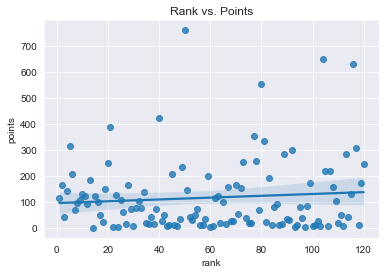

In [135]:
sns.regplot(x="rank", y="points", data=df).set(title="Rank vs. Points")

[Text(0.5, 1.0, 'Rank vs. Age in Hours')]

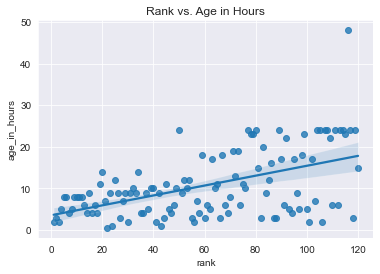

In [136]:
sns.regplot(x="rank", y="age_in_hours", data=df).set(title="Rank vs. Age in Hours")

### Analysis
Based on my analysis, in terms on a single linear regression of rank against age in hours is the strongest. The other features have an unacceptable amount of p-value to be considered valid for building this model. But when I fit `rank ~ points + age_in_hours`, it seems that the model fits the data much better, and the p-values are also acceptable for both the variable. At the time of current capture, the p-values for points and age in hours are both 0.000. Below I will provide a summary of a few different regressions.
<br  />


| $Formula$ | $R^2$ | $p-value(s)$ | $co-ef(s)$ |
|---|---|---|---|---|
| rank ~ points | 0.005 | 0.451 | 0.0189 |
| rank ~ age_in_hours | 0.273 | 0.000 | 2.4506 |
| rank ~ age_in_hours + points | 0.376 | 0.000, 0.000 | 3.6287, -0.1106|


<br  />


There seems to be a rough linear relationship between rank against age in hours. But it looks like the most reliable model can be created through a multiple regression of rank against points and age in hours. It makes up about 37.6% of the data based on my recording. But, this model is still inaccurate as it is not completely and is missing many other variables that could be affect this in addition to margin of error due to approximation of values such as age in hours after a day etc. The p-value of points in `rank ~ points` is marginally higher than what is acceptable. It basically shows the accuracy of using that variable being wrong, so basically lower is better, but the according to the standard, anything below a p-value of 0.005 is acceptable to be used in a model.


## Part 3 - Classification
As smart people, we know that your rank on HN doesn't matter, as long as you're on the front page. Use logistic regression to attempt to classify whether or not an article will be on the front page, given the other (non-rank) variables. Note, you'll need to transform the rank variable into an indicator variable (1 for front page, 0 for not), for example.

There are a number of (outdated) ranking formulas for HN publicly available. Take a look at least one of them and perform a regression using the formula to see if least squares regression can compute the coefficients correctly.

Include plots showing your regression (for the functions of 1 or 2 variables and your predicted score for an article). What do your regressions tell you about making the front page?

In [137]:
# Make category column
df['is_front_page'] = [1 if x <= 30 else 0 for x in df['rank']]
df.head()
#df.tail()

,rank,title_length,age_in_hours,points,comment_count,is_front_page
0,1,44,2.0,114,62,1
1,2,67,3.0,163,55,1
2,3,18,2.0,40,6,1
3,4,42,5.0,143,79,1
4,5,76,8.0,314,95,1


Optimization terminated successfully.
         Current function value: 0.491654
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          is_front_page   No. Observations:                  120
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 Jun 2022   Pseudo R-squ.:                  0.1257
Time:                        19:15:35   Log-Likelihood:                -58.999
converged:                       True   LL-Null:                       -67.480
Covariance Type:            nonrobust   LLR p-value:                 3.811e-05
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2230      0.394      0.566      0.572      -0.550       0.996
age_in_hours    -0.1533

<AxesSubplot:xlabel='age_in_hours', ylabel='is_front_page'>

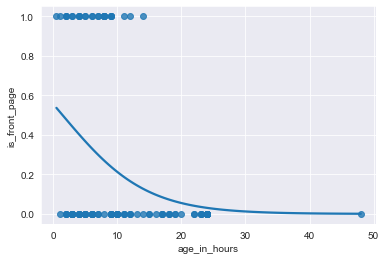

In [138]:
log_reg = smf.logit('is_front_page ~ age_in_hours', df).fit()
print(log_reg.summary())
sns.regplot(y='is_front_page', x='age_in_hours', logistic=True, data=df, ci=None)

Optimization terminated successfully.
         Current function value: 0.562291
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          is_front_page   No. Observations:                  120
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 Jun 2022   Pseudo R-squ.:               7.822e-05
Time:                        19:15:35   Log-Likelihood:                -67.475
converged:                       True   LL-Null:                       -67.480
Covariance Type:            nonrobust   LLR p-value:                    0.9182
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0803      0.276     -3.917      0.000      -1.621      -0.540
points        -0.0002      0.

<AxesSubplot:xlabel='points', ylabel='is_front_page'>

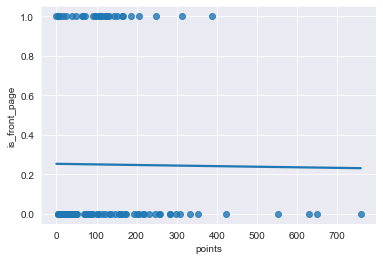

In [139]:
log_reg = smf.logit('is_front_page ~ points', df).fit()
print(log_reg.summary())
sns.regplot(y='is_front_page', x='points', logistic=True, data=df, ci=None)

Optimization terminated successfully.
         Current function value: 0.439059
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          is_front_page   No. Observations:                  120
Model:                          Logit   Df Residuals:                      117
Method:                           MLE   Df Model:                            2
Date:                Wed, 29 Jun 2022   Pseudo R-squ.:                  0.2192
Time:                        19:15:35   Log-Likelihood:                -52.687
converged:                       True   LL-Null:                       -67.480
Covariance Type:            nonrobust   LLR p-value:                 3.762e-07
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4281      0.423      1.012      0.311      -0.401       1.257
points           0.0092

(1.0, 121.0)

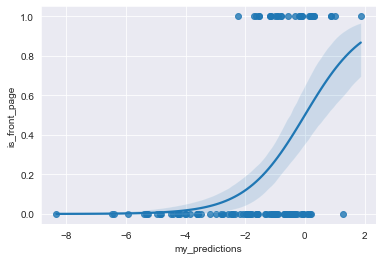

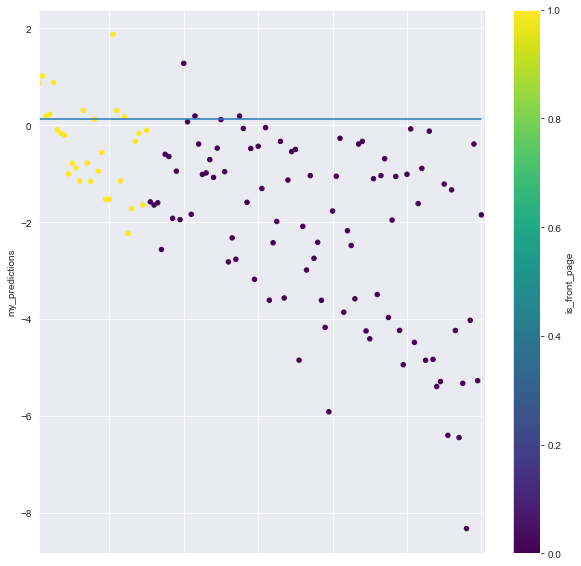

In [140]:
log_reg = smf.logit('is_front_page ~ points + age_in_hours', df).fit()
print(log_reg.summary())
p = log_reg.params
predictions = []
for index, row in df.iterrows() :
    predictions.append(p.Intercept + p.points * row.points + p.age_in_hours * row.age_in_hours)

df["my_predictions"] = predictions
sns.regplot(y='is_front_page', x='my_predictions', data=df, logistic=True)

ax = df.plot(x='rank', y='my_predictions', kind='scatter', c='is_front_page', colormap='viridis', figsize=[10,10])
print(df.head())

x=df['rank']
ax.plot(x, [p.Intercept + p.points + p.age_in_hours for x in range(1,121)])
ax.set_xlim([1, 121])

   rank  title_length  age_in_hours  points  comment_count  is_front_page  \
0     1            44           2.0     114             62              1   
1     2            67           3.0     163             55              1   
2     3            18           2.0      40              6              1   
3     4            42           5.0     143             79              1   
4     5            76           8.0     314             95              1   

   my_predictions  other_predictions  
0        0.867624           9.319025  
1        1.014000           8.940648  
2        0.188855           3.216301  
3        0.224389           4.276730  
4        0.883658           4.960716  


(1.0, 121.0)

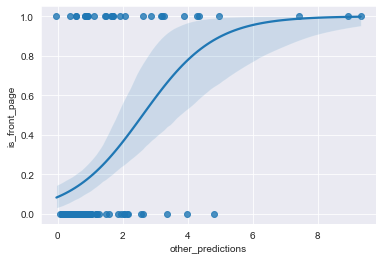

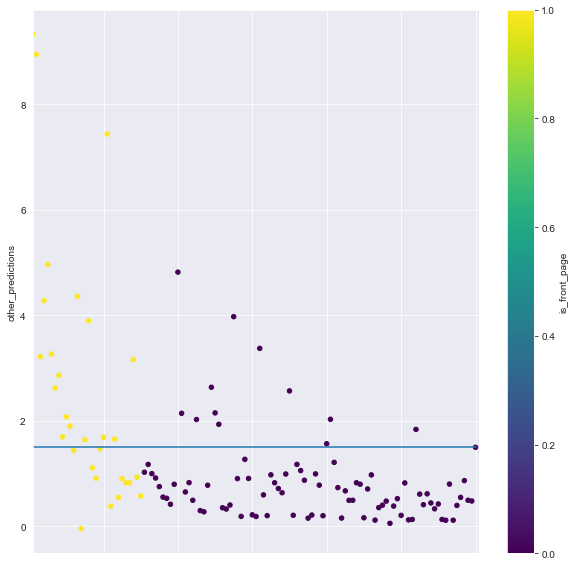

In [141]:
# Formula found online >> (points - 1) / (time + 2) ** 1.8
predictions = []
for index, row in df.iterrows():
    predictions.append((row.points - 1) / (row.age_in_hours + 2)**1.8)

df["other_predictions"] = predictions
sns.regplot(y='is_front_page', x='other_predictions', data=df, logistic=True)

ax = df.plot(x='rank', y='other_predictions', kind='scatter', c='is_front_page', colormap='viridis', figsize=[10, 10])
print(df.head())

x = df['rank']
ax.plot(x, [1.5 for x in range(1,121)])
ax.set_xlim([1, 121])